# Strategic Campaign Response Modeling – Phase 1

## Business Context
A retail bank recently concluded a large-scale term deposit acquisition campaign conducted via outbound phone calls.  
The marketing team now requires a data-driven framework to:

1. Identify customers most likely to respond positively to future campaigns.
2. Understand key customer attributes and behaviors that influence response.
3. Provide a baseline performance benchmark before evolving to a modern, multi-channel strategy.

This notebook represents **Phase 1** of a two-phase initiative.  
Phase 1 focuses on historical campaign data analysis and predictive modeling readiness; Phase 2 will incorporate additional communication channels, associated costs, and ROI-driven optimization.

---

## Phase 1 Objectives
- Clean and prepare the historical campaign dataset for predictive modeling.
- Explore the distribution and relationships of customer, product, and campaign attributes.
- Engineer a set of features that are **predictable before campaign launch** (avoiding leakage from post-contact variables).
- Deliver a fully prepared dataset ready for model development.

---

## Scope of Work
1. **Data Loading & Structure Review**  
   Load the dataset and confirm structure, data types, and basic completeness.

2. **Initial Data Quality Assessment**  
   Identify missing values, placeholders, and unusual entries.

3. **Data Cleaning**  
   Standardize formats, handle missing or placeholder values, and remove post-contact variables not available at targeting stage.

4. **Exploratory Data Analysis (EDA)**  
   Quantify the target variable distribution, assess key feature distributions, and highlight potential drivers of campaign response.

5. **Feature Engineering**  
   Encode categorical variables, drop irrelevant features, and prepare a finalized feature matrix.

6. **Dataset Export**  
   Produce a clean, documented dataset to serve as the input for Phase 1 modeling.

---

**End State:**  
A campaign-ready customer dataset that reflects only pre-contact information, with well-defined features suitable for predictive modeling and performance benchmarking.


In [1]:
#IMPORT PHASE
# Basic imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# For categorical encoding later
from sklearn.preprocessing import LabelEncoder

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: f'{x:.2f}')

# Load dataset
df = pd.read_csv('bank-additional-full.csv', sep=';') # path to your dataset

# Quick shape and peek
print(f"Shape: {df.shape}")
df.head()

Shape: (41188, 21)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.10,93.99,-36.40,4.86,5191.00,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.10,93.99,-36.40,4.86,5191.00,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.10,93.99,-36.40,4.86,5191.00,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.10,93.99,-36.40,4.86,5191.00,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.10,93.99,-36.40,4.86,5191.00,no


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

### Dataset Overview  
The dataset contains **41,188 records** from a retail bank’s historical term deposit campaigns, with **21 fields** capturing customer demographics, financial status, prior contact history, campaign interaction details, and macroeconomic indicators.  

### Field Definitions & Modeling Readiness  

| Column           | Description | Modeling Readiness Notes |
|------------------|-------------|--------------------------|
| age              | Customer age (years) | Suitable for modeling. Consider binning into age bands for interpretability. |
| job              | Type of job (e.g., admin., technician, blue-collar) | Suitable. Requires categorical encoding. |
| marital          | Marital status | Suitable. Requires categorical encoding. |
| education        | Education level (granular categories, e.g., basic.4y, university.degree) | Suitable. Requires categorical encoding; may need mapping for interpretability. |
| default          | Has credit in default? (yes, no, unknown) | Suitable. Replace `unknown` with NaN and impute or treat as category. |
| housing          | Has a housing loan? (yes, no, unknown) | Suitable. Handle `unknown` as above. |
| loan             | Has a personal loan? (yes, no, unknown) | Suitable. Handle `unknown` as above. |
| contact          | Communication type (cellular, telephone) | Suitable for baseline; could be expanded for multi-channel analysis. |
| month            | Last contact month | Suitable; may carry seasonality effects. Encode as ordered or cyclic features. |
| day_of_week      | Day of the week of last contact | Suitable; may capture weekday effects. Encode as ordered or cyclic features. |
| duration         | Last contact duration (seconds) | Post-contact variable – exclude from pre-contact modeling to avoid leakage. |
| campaign         | Number of contacts during this campaign for the customer | Suitable; may correlate with contact fatigue. |
| pdays            | Days since last contact from a previous campaign (999 = never contacted) | Suitable after transforming 999 to a dedicated category or NaN. |
| previous         | Number of contacts before this campaign | Suitable; reflects past engagement history. |
| poutcome         | Outcome of the previous marketing campaign | Suitable; may have strong predictive power. |
| emp.var.rate     | Quarterly employment variation rate | Suitable macroeconomic indicator. Requires scaling. |
| cons.price.idx   | Consumer price index | Suitable macroeconomic indicator. Requires scaling. |
| cons.conf.idx    | Consumer confidence index | Suitable macroeconomic indicator. Requires scaling. |
| euribor3m        | 3-month Euribor rate | Suitable macroeconomic indicator. Requires scaling. |
| nr.employed      | Number of employees | Suitable macroeconomic indicator. Requires scaling. |
| y                | Target variable – did the client subscribe to a term deposit? (yes, no) | Binary target. Encode as 1 = yes, 0 = no. |

**Note:** Only features available **before** campaign execution will be used in modeling. Any post-contact information (e.g., `duration`) will be excluded to ensure real-world applicability.




In [3]:
#Initial checks

# Check unique values for each column
for col in df.columns:
    print(f"{col}: {df[col].nunique()} unique values")

age: 78 unique values
job: 12 unique values
marital: 4 unique values
education: 8 unique values
default: 3 unique values
housing: 3 unique values
loan: 3 unique values
contact: 2 unique values
month: 10 unique values
day_of_week: 5 unique values
duration: 1544 unique values
campaign: 42 unique values
pdays: 27 unique values
previous: 8 unique values
poutcome: 3 unique values
emp.var.rate: 10 unique values
cons.price.idx: 26 unique values
cons.conf.idx: 26 unique values
euribor3m: 316 unique values
nr.employed: 11 unique values
y: 2 unique values


## Variable Cardinality Review & Modeling Implications

- **Low-cardinality categoricals**  
  `job` (12), `marital` (4), `education` (8), `default` (3), `housing` (3), `loan` (3), `contact` (2), `month` (10), `day_of_week` (5), `poutcome` (3), `y` (2).  
  → Suitable for one-hot or label encoding. Low risk of overfitting from high cardinality.

- **High-cardinality numericals**  
  `age` (78), `duration` (1544), `campaign` (42), `pdays` (27), `previous` (8), `emp.var.rate` (10), `cons.price.idx` (26), `cons.conf.idx` (26), `euribor3m` (316), `nr.employed` (11).  
  → Continuous or count-type variables; may require scaling, binning, or transformation to reduce skew.  
  → **`duration`** flagged as post-contact — to be excluded from predictive features.

- **Special handling candidates**  
  - `pdays`: `999` indicates never contacted before — convert to a dedicated category or NaN before modeling.  
  - `campaign`: potential indicator of contact fatigue — consider capping extreme values.  
  - `month` & `day_of_week`: temporal variables — may capture seasonality or scheduling effects; encode as ordered or cyclic.

In [4]:
# Target variable distribution
df['y'].value_counts(normalize=True)

y
no    0.89
yes   0.11
Name: proportion, dtype: float64

## Target Variable Distribution

The target variable `y` shows a significant class imbalance:
- **No**: 89%
- **Yes**: 11%

This imbalance is typical in direct marketing campaigns where most customers decline the offer.  
Implications for modeling:
- Accuracy is not an appropriate performance metric — models could achieve 89% accuracy by predicting "No" for all customers.
- Precision, recall, F1-score, and PR-AUC will be prioritized to evaluate performance.
- Cost-sensitive learning or resampling techniques (SMOTE, stratified undersampling) may be considered to address imbalance during model training.

In [5]:
# Replace 'unknown' with NaN
df = df.replace('unknown', np.nan)

# Percentage of missing per column
missing_pct = df.isnull().mean() * 100
print(missing_pct[missing_pct > 0])

job          0.80
marital      0.19
education    4.20
default     20.87
housing      2.40
loan         2.40
dtype: float64


In [9]:
for col in ['job', 'education', 'default', 'housing', 'loan', 'marital']:
    df[col] = df[col].fillna('unknown')

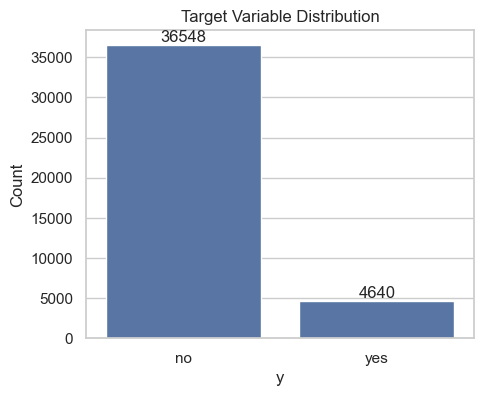

Class proportions:
y
no    0.89
yes   0.11
Name: proportion, dtype: float64


,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y_bin
count,41188.00,41188.00,41188.00,41188.00,41188.00,41188.00,41188.00,41188.00,41188.00,41188.00,41188.00
mean,40.02,258.29,2.57,962.48,0.17,0.08,93.58,-40.50,3.62,5167.04,0.11
std,10.42,259.28,2.77,186.91,0.49,1.57,0.58,4.63,1.73,72.25,0.32
min,17.00,0.00,1.00,0.00,0.00,-3.40,92.20,-50.80,0.63,4963.60,0.00
25%,32.00,102.00,1.00,999.00,0.00,-1.80,93.08,-42.70,1.34,5099.10,0.00
50%,38.00,180.00,2.00,999.00,0.00,1.10,93.75,-41.80,4.86,5191.00,0.00
75%,47.00,319.00,3.00,999.00,0.00,1.40,93.99,-36.40,4.96,5228.10,0.00
max,98.00,4918.00,56.00,999.00,7.00,1.40,94.77,-26.90,5.04,5228.10,1.00


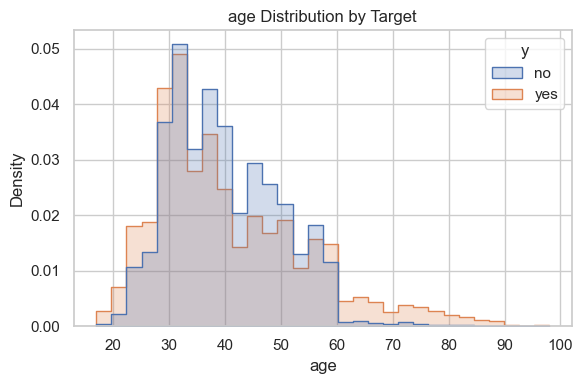

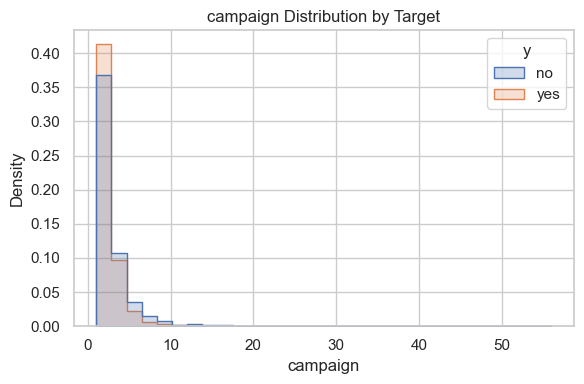

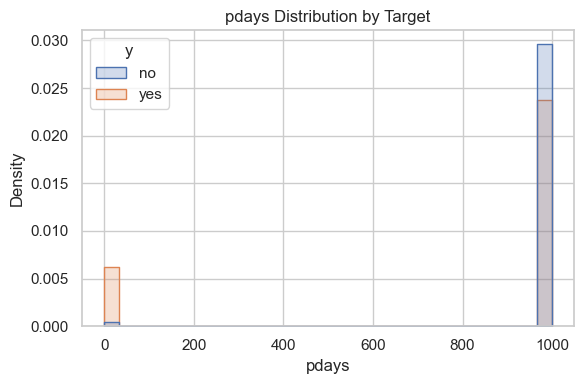

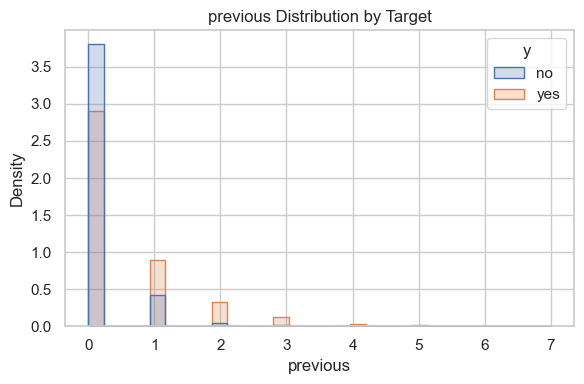

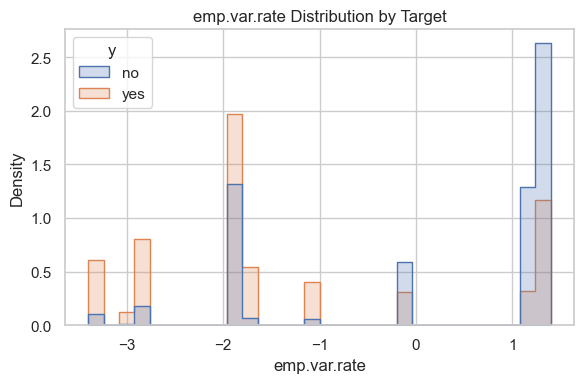

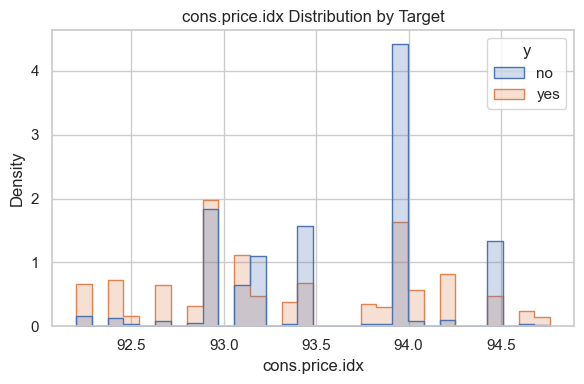

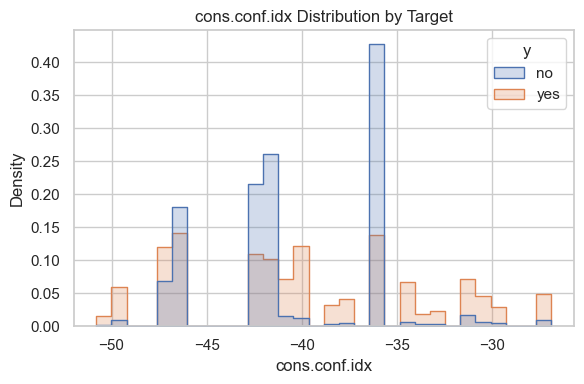

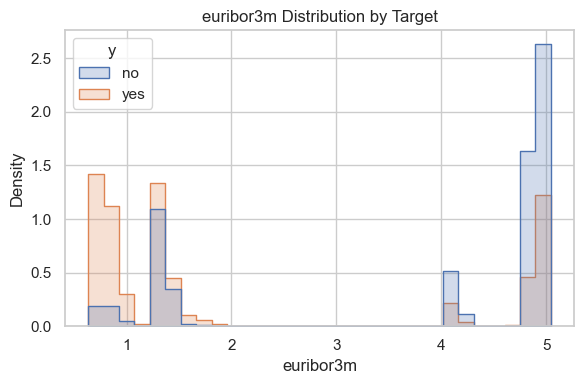

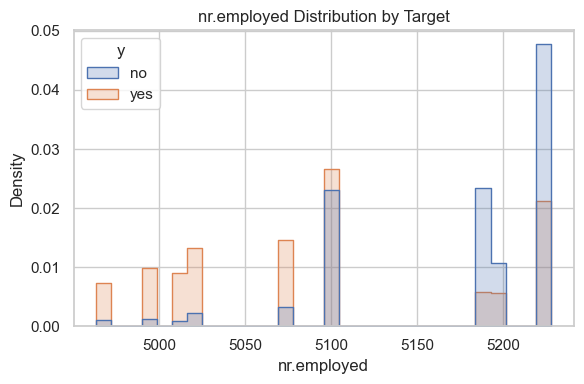

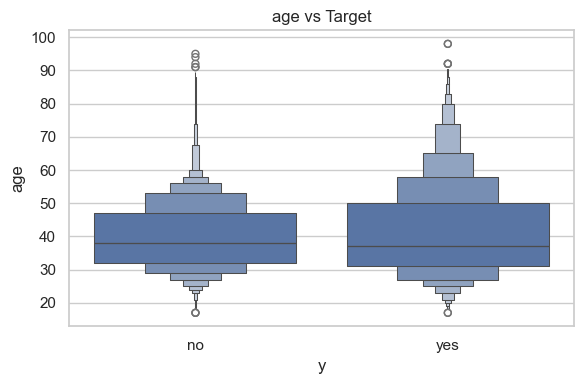

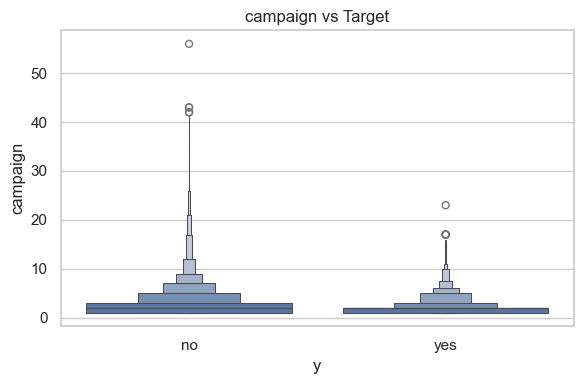

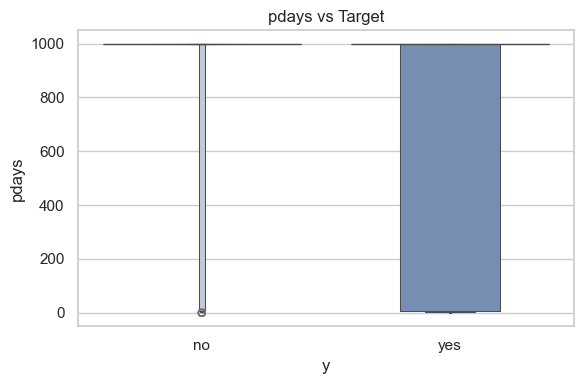

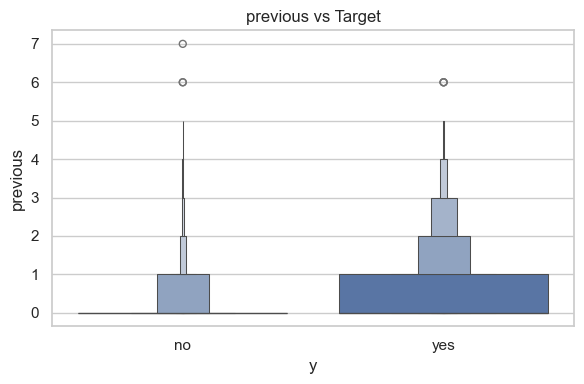

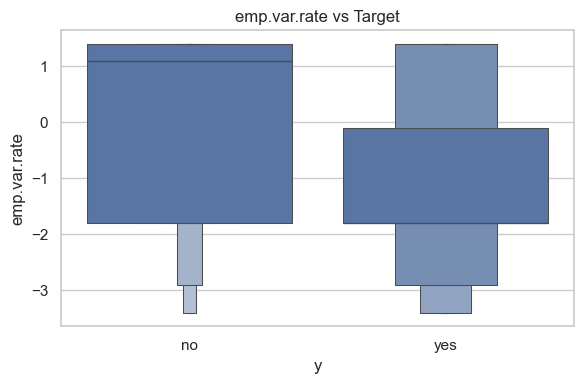

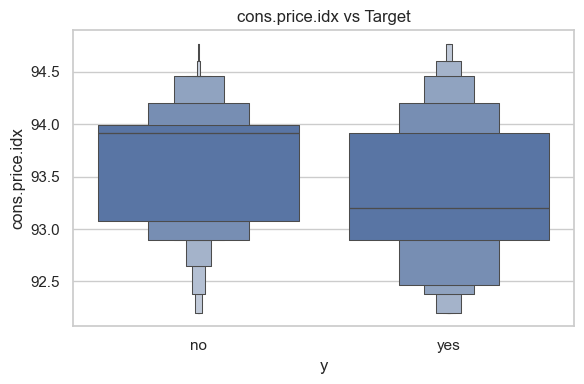

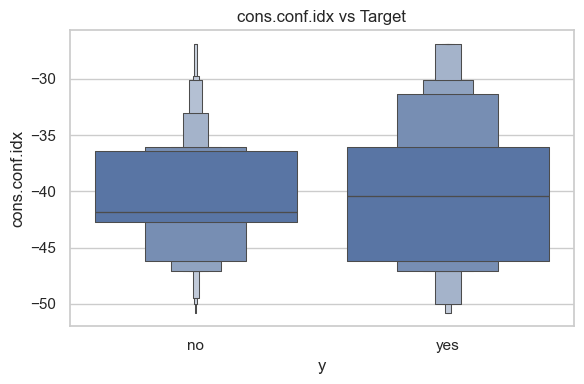

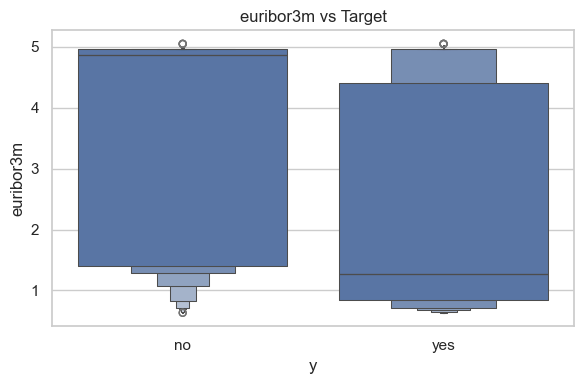

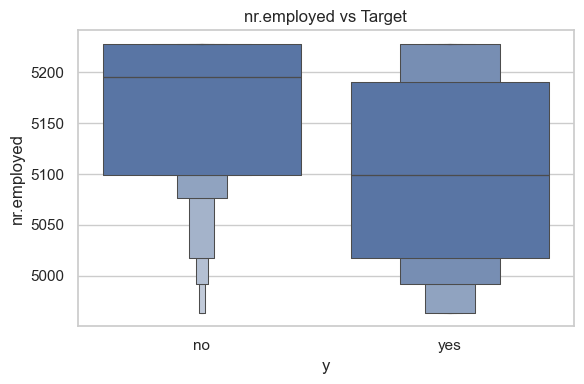

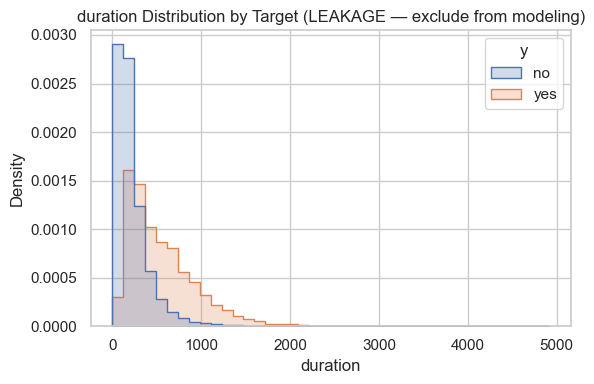

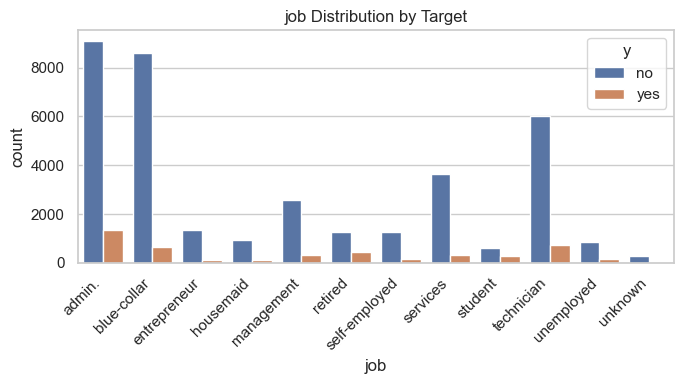

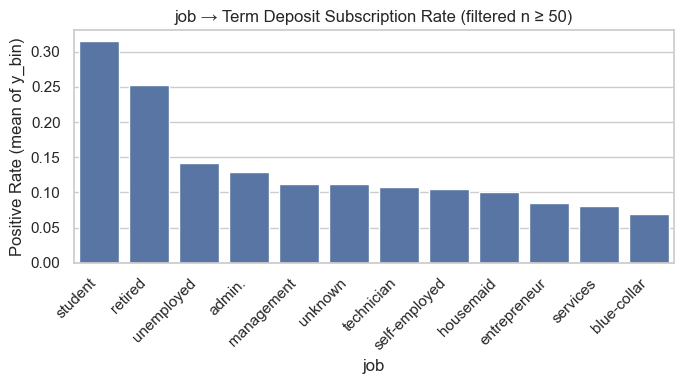

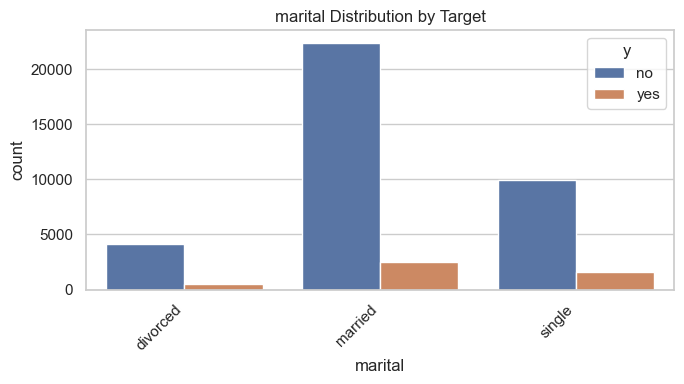

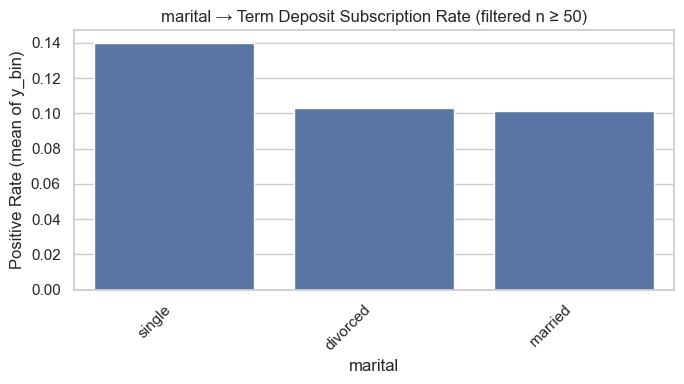

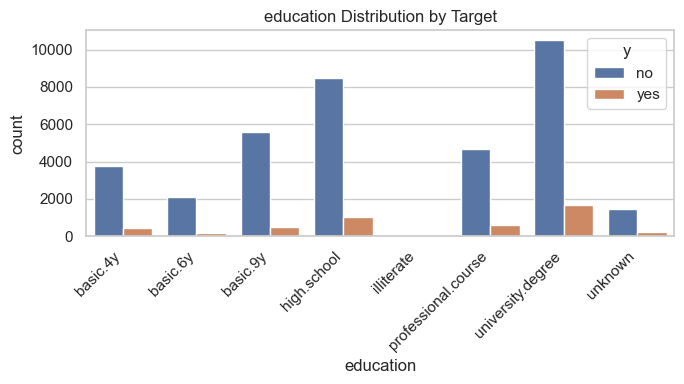

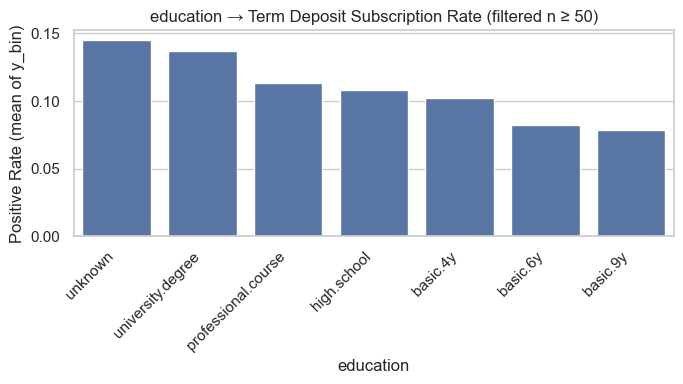

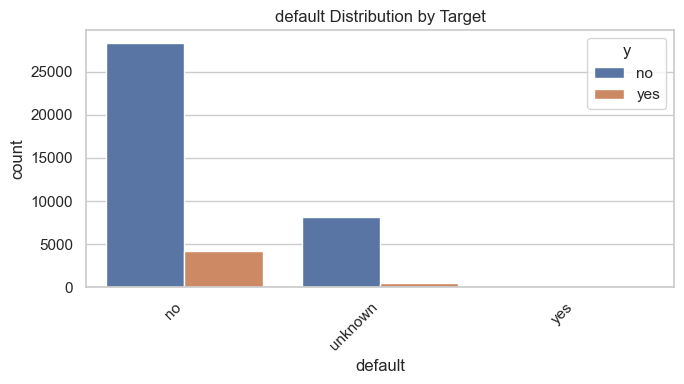

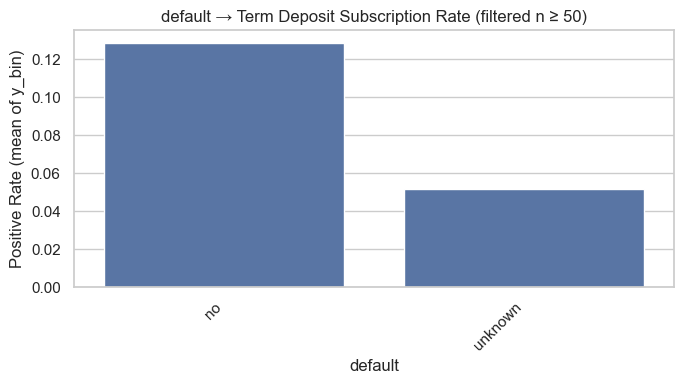

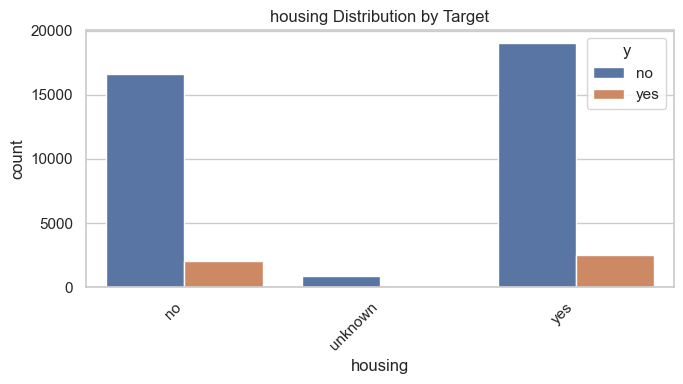

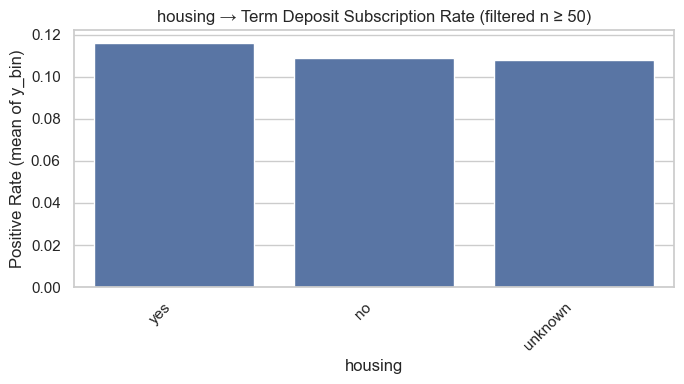

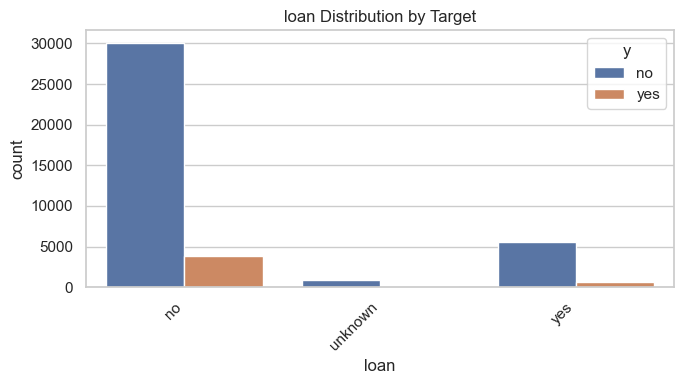

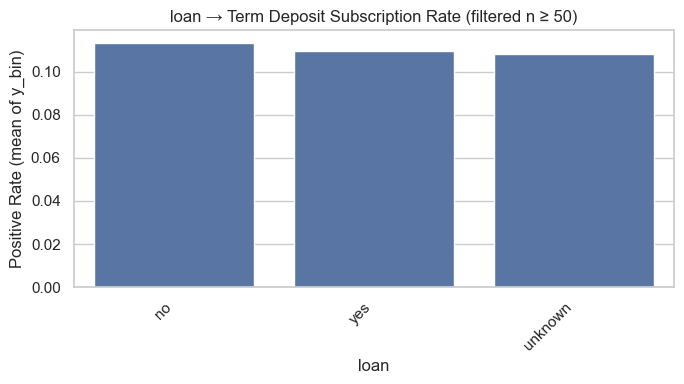

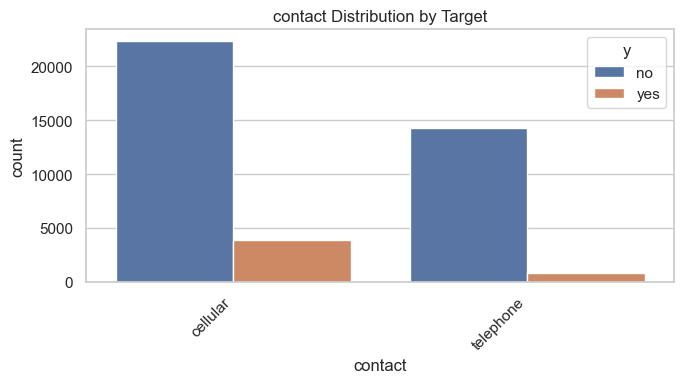

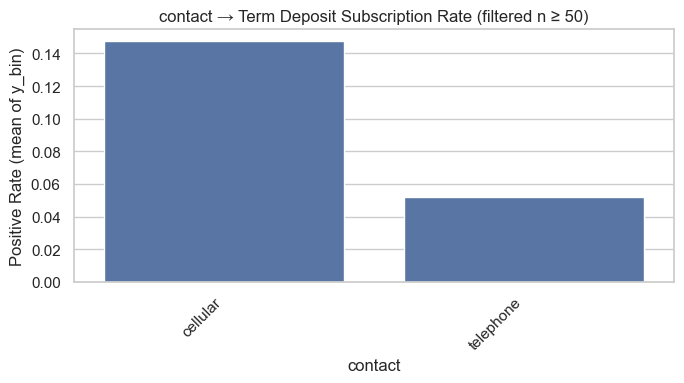

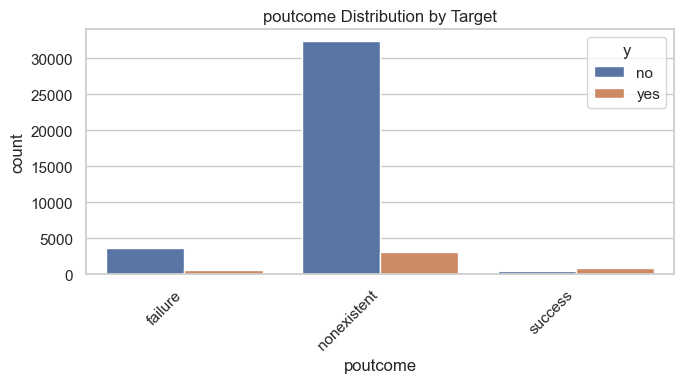

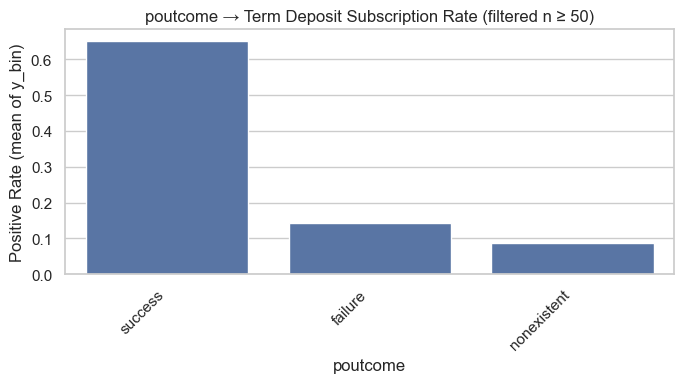

In [11]:
import seaborn as sns

sns.set_theme(style="whitegrid")

# Config
TARGET = "y"
POS_LABEL = "yes"   # in this dataset y ∈ {"yes","no"}
LEAK_FEATURES = ["duration"]  # keep for EDA, exclude from modeling
ORDERED_MONTHS = ["mar","apr","may","jun","jul","aug","sep","oct","nov","dec"]
ORDERED_DOW = ["mon","tue","wed","thu","fri"]

# Map target to binary
df["y_bin"] = (df[TARGET] == POS_LABEL).astype(int)

# Order month/day_of_week if present
if "month" in df.columns:
    df["month"] = pd.Categorical(df["month"], categories=ORDERED_MONTHS, ordered=True)
if "day_of_week" in df.columns:
    df["day_of_week"] = pd.Categorical(df["day_of_week"], categories=ORDERED_DOW, ordered=True)

# Target distribution
plt.figure(figsize=(5,4))
ax = sns.countplot(x=TARGET, data=df)
ax.bar_label(ax.containers[0])
plt.title("Target Variable Distribution")
plt.ylabel("Count")
plt.show()

print("Class proportions:")
print(df[TARGET].value_counts(normalize=True).rename("proportion").round(3))

# Numeric summary
display(df.select_dtypes(include=[np.number]).describe())


# Numeric distributions by target
num_cols = df.select_dtypes(include=np.number).columns.tolist()
# Keep duration separate (leakage) but include it in EDA
num_cols_no_leak = [c for c in num_cols if c not in LEAK_FEATURES and c != "y_bin"]

for col in num_cols_no_leak:
    plt.figure(figsize=(6,4))
    sns.histplot(data=df, x=col, hue=TARGET, element="step", bins=30, stat="density", common_norm=False)
    plt.title(f"{col} Distribution by Target")
    plt.tight_layout()
    plt.show()

# Optional: boxenplots for robustness to outliers
for col in num_cols_no_leak:
    plt.figure(figsize=(6,4))
    sns.boxenplot(x=TARGET, y=col, data=df)
    plt.title(f"{col} vs Target")
    plt.tight_layout()
    plt.show()

# Leakage feature (duration) — EDA only 
if "duration" in df.columns:
    plt.figure(figsize=(6,4))
    sns.histplot(data=df, x="duration", hue=TARGET, element="step", bins=40, stat="density", common_norm=False)
    plt.title("duration Distribution by Target (LEAKAGE — exclude from modeling)")
    plt.tight_layout()
    plt.show()

# Categorical distributions & positive rates
cat_cols = df.select_dtypes(include="object").columns.drop(TARGET, errors="ignore")

def plot_cat_counts(col, top_n=None):
    """Bar count by target (stacked proportions)."""
    tmp = (df.groupby([col, TARGET]).size()
             .reset_index(name="count"))
    # Order categories by total count
    order = tmp.groupby(col)["count"].sum().sort_values(ascending=False).index
    if top_n is not None and len(order) > top_n:
        order = order[:top_n]

    plt.figure(figsize=(7,4))
    sns.barplot(data=tmp[tmp[col].isin(order)], x=col, y="count", hue=TARGET)
    plt.xticks(rotation=45, ha="right")
    plt.title(f"{col} Distribution by Target")
    plt.tight_layout()
    plt.show()

def plot_cat_rate(col, min_count=50):
    """Positive rate (y_bin mean) per category with count filter to reduce noise."""
    agg = (df.groupby(col)
             .agg(pos_rate=("y_bin", "mean"), count=("y_bin", "size"))
             .reset_index())
    agg = agg.sort_values("pos_rate", ascending=False)
    agg_filtered = agg[agg["count"] >= min_count] if min_count else agg

    plt.figure(figsize=(7,4))
    sns.barplot(data=agg_filtered, x=col, y="pos_rate")
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("Positive Rate (mean of y_bin)")
    plt.title(f"{col} → Term Deposit Subscription Rate (filtered n ≥ {min_count})")
    plt.tight_layout()
    plt.show()

# Plot a quick view for each categorical: counts + positive rate
for col in cat_cols:
    # Keep nice ordering if month/day_of_week
    if col == "month":
        order = ORDERED_MONTHS
    elif col == "day_of_week":
        order = ORDERED_DOW
    else:
        order = None

    # Counts
    plot_cat_counts(col)

    # Positive rate per category
    plot_cat_rate(col, min_count=50)

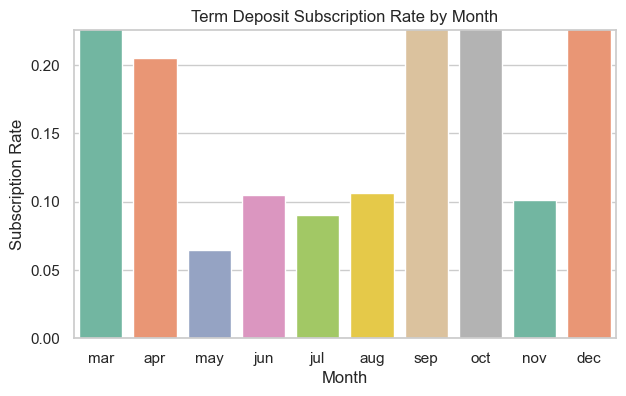

In [12]:
# --- Dedicated Month Plot (Ordered) ---
ORDERED_MONTHS = ["mar","apr","may","jun","jul","aug","sep","oct","nov","dec"]
df["month"] = pd.Categorical(df["month"], categories=ORDERED_MONTHS, ordered=True)

plt.figure(figsize=(7,4))
sns.barplot(data=df, x="month", y="y_bin", ci=None, palette="Set2")
plt.ylabel("Subscription Rate")
plt.xlabel("Month")
plt.title("Term Deposit Subscription Rate by Month")
plt.ylim(0, df["y_bin"].mean()*2)  # gives a nice scale around the average
plt.show()


### Top 5 Drivers of Term Deposit Subscription (EDA Summary)

1. **Previous Campaign Success** – Customers who previously said “yes” are far more likely to subscribe again.  
2. **Job Type** – Retired, student, and unemployed customers convert at much higher rates than other occupations.  
3. **Contact Month** – March, September, October, and December show stronger conversion; summer months underperform.  
4. **Education Level** – Higher education levels (university, professional) correlate with higher subscription likelihood.  
5. **Contact Type** – Cellular outreach is consistently more effective than telephone contacts.

In [13]:
df.pdays.value_counts().sort_index()

pdays
0         15
1         26
2         61
3        439
4        118
5         46
6        412
7         60
8         18
9         64
10        52
11        28
12        58
13        36
14        20
15        24
16        11
17         8
18         7
19         3
20         1
21         2
22         3
25         1
26         1
27         1
999    39673
Name: count, dtype: int64

In [14]:
# --------------------------
# 1) Handle 'pdays'
# --------------------------
# Binary flag: was previously contacted?
df['was_contacted_before'] = (df['pdays'] != 999).astype(int)

# Replace 999 (never contacted) with NaN so stats/algos treat it as missing distance
df['pdays'] = df['pdays'].replace(999, np.nan)

# --------------------------
# 2) Handle 'duration' (leakage)
# --------------------------
if 'duration' in df.columns:
    df = df.drop(columns=['duration'])

# --------------------------
# 3) Encode month & day_of_week in proper order
# --------------------------
MONTH_ORDER = ['mar','apr','may','jun','jul','aug','sep','oct','nov','dec']
DOW_ORDER = ['mon','tue','wed','thu','fri']

if 'month' in df.columns:
    present_months = [m for m in MONTH_ORDER if m in df['month'].unique()]
    df['month'] = pd.Categorical(df['month'], categories=present_months, ordered=True)

if 'day_of_week' in df.columns:
    present_dow = [d for d in DOW_ORDER if d in df['day_of_week'].unique()]
    df['day_of_week'] = pd.Categorical(df['day_of_week'], categories=present_dow, ordered=True)

# --------------------------
# 4) Encode target y (yes/no -> 1/0)
# --------------------------
df['y'] = df['y'].map({'yes': 1, 'no': 0}).astype('Int64')  # Int64 keeps NA-safe if any

# --------------------------
# 5) One-hot encode categoricals (incl. default/housing/loan with 'unknown')
# --------------------------
cat_cols = df.select_dtypes(include='object').columns.tolist()

# Safety: remove target if it's still object for any reason
cat_cols = [c for c in cat_cols if c != 'y']

# Get dummies; keep full rank (no drop_first) to preserve 'unknown' categories explicitly
df = pd.get_dummies(df, columns=cat_cols, drop_first=False)

# Final check
print(df.head())

   age month day_of_week  campaign  pdays  previous  emp.var.rate  \
0   56   may         mon         1    NaN         0          1.10   
1   57   may         mon         1    NaN         0          1.10   
2   37   may         mon         1    NaN         0          1.10   
3   40   may         mon         1    NaN         0          1.10   
4   56   may         mon         1    NaN         0          1.10   

   cons.price.idx  cons.conf.idx  euribor3m  nr.employed  y  y_bin  \
0           93.99         -36.40       4.86      5191.00  0      0   
1           93.99         -36.40       4.86      5191.00  0      0   
2           93.99         -36.40       4.86      5191.00  0      0   
3           93.99         -36.40       4.86      5191.00  0      0   
4           93.99         -36.40       4.86      5191.00  0      0   

   was_contacted_before  job_admin.  job_blue-collar  job_entrepreneur  \
0                     0       False            False             False   
1               

In [15]:
# --- Encode month/day_of_week (choose ONE approach) ---

# A) Ordered numeric codes (good for tree models)
if 'month' in df.columns:
    MONTH_ORDER = ['mar','apr','may','jun','jul','aug','sep','oct','nov','dec']
    present = [m for m in MONTH_ORDER if m in df['month'].unique()]
    df['month'] = pd.Categorical(df['month'], categories=present, ordered=True)
    df['month_code'] = df['month'].cat.codes  # -1 if NA
    df.drop(columns=['month'], inplace=True)

if 'day_of_week' in df.columns:
    DOW_ORDER = ['mon','tue','wed','thu','fri']
    present = [d for d in DOW_ORDER if d in df['day_of_week'].unique()]
    df['day_of_week'] = pd.Categorical(df['day_of_week'], categories=present, ordered=True)
    df['dow_code'] = df['day_of_week'].cat.codes  # -1 if NA
    df.drop(columns=['day_of_week'], inplace=True)

# (OR) B) One-hot encode them instead:
# df = pd.get_dummies(df, columns=['month','day_of_week'], drop_first=False)

# --- Booleans -> 0/1 ---
bool_cols = df.select_dtypes(include='bool').columns
df[bool_cols] = df[bool_cols].astype('uint8')

# --- Keep a single target ---
if 'y_bin' in df.columns:
    df.drop(columns=['y_bin'], inplace=True)

# --- Optional: pdays missing indicator, and simple impute ---
df['pdays_is_missing'] = df['pdays'].isna().astype('uint8')
# If using sklearn models that require no NaNs:
# df['pdays'] = df['pdays'].fillna(df['pdays'].median())

# --- Sanity check: no object dtypes left ---
print("Remaining object dtypes:", df.select_dtypes(include='object').columns.tolist())
print(df.head())

Remaining object dtypes: []
   age  campaign  pdays  previous  emp.var.rate  cons.price.idx  \
0   56         1    NaN         0          1.10           93.99   
1   57         1    NaN         0          1.10           93.99   
2   37         1    NaN         0          1.10           93.99   
3   40         1    NaN         0          1.10           93.99   
4   56         1    NaN         0          1.10           93.99   

   cons.conf.idx  euribor3m  nr.employed  y  was_contacted_before  job_admin.  \
0         -36.40       4.86      5191.00  0                     0           0   
1         -36.40       4.86      5191.00  0                     0           0   
2         -36.40       4.86      5191.00  0                     0           0   
3         -36.40       4.86      5191.00  0                     0           1   
4         -36.40       4.86      5191.00  0                     0           0   

   job_blue-collar  job_entrepreneur  job_housemaid  job_management  \
0          

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 51 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            41188 non-null  int64  
 1   campaign                       41188 non-null  int64  
 2   pdays                          1515 non-null   float64
 3   previous                       41188 non-null  int64  
 4   emp.var.rate                   41188 non-null  float64
 5   cons.price.idx                 41188 non-null  float64
 6   cons.conf.idx                  41188 non-null  float64
 7   euribor3m                      41188 non-null  float64
 8   nr.employed                    41188 non-null  float64
 9   y                              41188 non-null  Int64  
 10  was_contacted_before           41188 non-null  int64  
 11  job_admin.                     41188 non-null  uint8  
 12  job_blue-collar                41188 non-null 

In [18]:
# SANITY CHECK
# target present and binary?
df['y'].value_counts(dropna=False)

# no NaNs except pdays (by design)?
df.isna().sum().sort_values(ascending=False).head(10)

pdays                            39673
age                                  0
housing_unknown                      0
education_basic.9y                   0
education_high.school                0
education_illiterate                 0
education_professional.course        0
education_university.degree          0
education_unknown                    0
default_no                           0
dtype: int64

In [20]:
#df.to_csv('/bank_marketing_clean.csv', index=False)  # uncheck and save the resulting dataset where you want to store it


### Feature Engineering Summary

The dataset (`bank_marketing_clean.csv`) is derived from the original bank marketing dataset with the following transformations:

1. **Target Encoding**
   - `y`: Mapped `yes` → 1, `no` → 0 (binary target).

2. **Leakage Removal**
   - Dropped `duration` (only known after contact).

3. **`pdays` Handling**
   - Created `was_contacted_before`: 1 if `pdays` != 999, else 0.
   - Replaced `999` with `NaN` in `pdays` for clarity.
   - Added `pdays_is_missing` flag to capture missingness signal.

4. **Date-Related Features**
   - Encoded `month` as ordered integer (`month_code`), keeping chronological order.
   - Encoded `day_of_week` as ordered integer (`dow_code`).

5. **Categorical Encoding**
   - All categorical features (`job`, `marital`, `education`, `default`, `housing`, `loan`, `contact`, `poutcome`) one-hot encoded.
   - `"unknown"` categories retained as explicit dummy columns.

6. **Data Types Optimization**
   - Dummies stored as `uint8`, ordered codes as `int8`, continuous variables kept in appropriate numeric types.

7. **Missing Values**
   - No `object` columns remain.
   - Only `pdays` contains `NaN` (by design), with missingness captured by `pdays_is_missing`.

**Final Dataset Shape**: 41,188 rows × 51 columns. All features are numeric and modeling-ready.